In [1]:
!pip install q keras==2.12.0
!pip install segmentation_models
!pip install tensorflow==2.12.0
!pip install tensorflow-io==0.32.0 
!pip install kaggle

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
import tensorflow_io as tfio
import keras
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow
import keras
import cv2
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
focal_loss = sm.losses.cce_dice_loss
import random
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

Segmentation Models: using `tf.keras` framework.


In [3]:
#loading the dataframe containing images after removing conflicting images
df=pd.read_csv('train_masks.csv')
img=pd.read_csv('dup_rem.csv')
print(len(img))
img.drop('Unnamed: 0',axis=1,inplace=True)
img.image_name=img.image_name.astype(int)
img.subject_name=img.subject_name.astype(int)
img.columns=['image_path','img','subject','mask_path']
new_df=pd.merge(img,df,on=['img','subject'])
new_df.pixels.fillna(0,inplace=True)
val=[0 if i==0 else 1 for i in new_df.pixels]
new_df['mask_pres']=val
print(new_df.shape)

5391
(5391, 6)


In [4]:
train_path = new_df.image_path
test_path = os.listdir('./test')

In [5]:
train_image = new_df.image_path
train_mask = new_df.mask_path
# print((len(train_image[0])))

train/1_113.tif
train/1_113_mask.tif
train/31_71.tif
train/31_71_mask.tif
train/14_112.tif
train/14_112_mask.tif


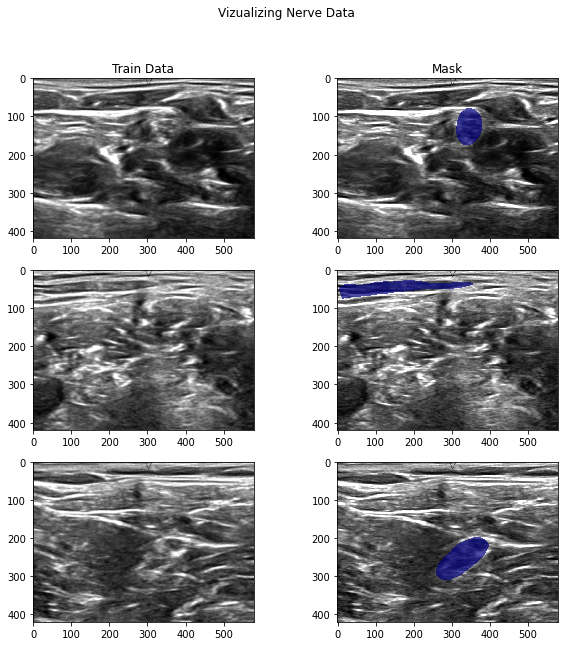

In [6]:
fig , ax = plt.subplots(3 , 2 , figsize=[10 , 10])
fig.suptitle('Vizualizing Nerve Data')
ax[0 , 0].set_title('Train Data')
ax[0 , 1].set_title('Mask')

# print(ax.shape)
for i in range(0 , 3):
  ind = random.randint(0 , len(train_image))
  img1 = np.array(Image.open( str(train_image[ind])))
  ax[i , 0].imshow(img1 , cmap = 'gray')
  print(str(train_image[ind]))
  img2 = np.array(Image.open(str(train_mask[ind])))
  print(str(train_mask[ind]))
  img2 = np.ma.masked_where(img2 == 0, img2)
  ax[i , 1].imshow(img1 , cmap = 'gray' , interpolation = 'none')
  ax[i , 1].imshow(img2 , cmap = 'jet', interpolation = 'none', alpha = 0.7)
    
plt.show()

In [7]:
img_size=256

In [8]:
X = np.zeros((len(train_image), img_size, img_size, 1), dtype=np.float32)
y = np.zeros((len(train_image), img_size, img_size, 1), dtype=np.float32)

In [9]:
import numpy as np
import skimage
from skimage.transform import resize
from scipy.ndimage import rotate
for n , img_name in enumerate(train_image):
  img = tf.keras.preprocessing.image.load_img(img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (img_size , img_size , 1) , mode = 'constant' , preserve_range = True)
  X[n] = in_img / 255.0
  
for n , img_name in enumerate(train_mask):
  img = tf.keras.preprocessing.image.load_img(img_name , grayscale=True)
  in_img = tf.keras.preprocessing.image.img_to_array(img)
  in_img = skimage.transform.resize(in_img , (img_size , img_size , 1) , mode = 'constant' , preserve_range = True)
  y[n] = in_img / 255.0
# for n in range(len(X)):
#     if np.random.uniform(0, 1) < 0.1:
#         X[n] = np.fliplr(X[n])
#         y[n] = np.fliplr(y[n])
#     elif np.random.uniform(0, 1) < 0.2:
#         X[n] = np.flipud(X[n])
#         y[n] = np.flipud(y[n])
#     elif np.random.uniform(0, 1) < 0.3:
#         angle = np.random.randint(0, 360)  # Random angle between 0 and 360 degrees
#         X[n] = rotate(X[n], angle, reshape=False, mode='reflect')
#         y[n] = rotate(y[n], angle, reshape=False, mode='reflect')

/opt/conda/lib/python3.8/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [10]:
y.shape

(5391, 256, 256, 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train , X_valid , y_train , y_valid = train_test_split(X , y , test_size = 0.2 , random_state = 42)

HR Net

In [12]:
!pip install deep-learning-utils

     |████████████████████████████████| 154 kB 25.0 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 26.0 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 16.5 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 23.8 MB/s eta 0:00:01
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144574 sha256=22c0260d6a8271b115a284474b2cfd8075b5ddad5c1af21883ac47146e3462ac
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33.2:
      Successfully uninstalled grpcio-1.33.2


In [13]:
# from utils.loss import *
# from utils.metrics import *
# from dataloaders.generater import *
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.utils import training_utils
# from keras.utils.training_utils import multi_gpu_model

In [25]:

# from keras.utils import np_utils
# import numpy as np
# import tifffile
# from glob import glob
# import os
# # from typing_extensions import Concatenate
# from albumentations import (
#     Compose,
#     HorizontalFlip,    # 随机水平翻转
#     VerticalFlip,      # 随机垂直翻转
#     RandomRotate90,    # 随机90度旋转
#     RandomSizedCrop    # 随机尺寸裁剪并缩放回原始大小
# )


# # 1. 读取数据路径
# def get_data_paths(train_images_dir, test_images_dir, seed=37):
#     train_images_paths = glob(os.path.join(train_images_dir, '*.tif'))
#     test_images_paths = glob(os.path.join(test_images_dir, '*.tif'))

#     # 随机打乱训练数据
#     np.random.seed(seed)
#     np.random.shuffle(train_images_paths)

#     return train_images_paths, test_images_paths


# # 2. 获取batch data
# def batch_generator(train_images_paths, batch_size, flag):
#     while 1:
#         for i in range(0, len(train_images_paths), batch_size):
#             idx_start = 0 if (i + batch_size) > len(train_images_paths) else i
#             idx_end = idx_start + batch_size
#             if flag == 'train':
#                 images, gts = read_train_img(train_images_paths[idx_start: idx_end])
#             else:
#                 images, gts = read_test_img(train_images_paths[idx_start: idx_end])
#             yield (images, gts)


# # 3. 读取一个batch的图片并进行实时数据扩充
# def read_train_img(images_paths):
#     images = []
#     gts = []
#     for image_path in images_paths:
#         gt_path = image_path.replace('images', 'gt')

#         image = tifffile.imread(image_path)
#         gt = tifffile.imread(gt_path)

#         # 数据扩充
#         h, w = image.shape[0], image.shape[1]
#         aug = Compose([VerticalFlip(p=0.5),
#                        RandomRotate90(p=0.5),
#                        HorizontalFlip(p=0.5),
#                        RandomSizedCrop(min_max_height=(128, 512), height=h, width=w, p=0.5)])

#         augmented = aug(image=image, mask=gt)
#         image = augmented['image']
#         gt = augmented['mask']

#         # 数据预处理
#         image = image / 255.0
#         gt_temp = gt.copy()
#         gt[gt_temp == 255] = 1
#         gt = np.expand_dims(gt, axis=2)
#         # gt = np_utils.to_categorical(gt, num_classes=1)

#         images.append(image)
#         gts.append(gt)

# #     return np.array(images), np.array(gts)
#         return tf.stack(images), tf.stack(gts)


# # 4. 读取一个batch的验证图片
# def read_test_img(images_paths):
#     images = []
#     gts = []
#     for image_path in images_paths:
#         gt_path = image_path.replace('images', 'gt')

#         image = tifffile.imread(image_path)
#         gt = tifffile.imread(gt_path)

#         # 数据预处理
#         image = image / 255.0
#         gt_temp = gt.copy()
#         gt[gt_temp == 255] = 1
#         gt = np.expand_dims(gt, axis=2)
#         # gt = np_utils.to_categorical(gt, num_classes=1)

#         images.append(image)
#         gts.append(gt)

#     return np.array(images), np.array(gts)

ImportError: cannot import name 'Concatenate' from 'typing_extensions' (/opt/conda/lib/python3.8/site-packages/typing_extensions.py)

In [26]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    # x = BatchNormalization(axis=3)(x)
    # x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))

    x = stem_net(inputs)

    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model


# from keras.utils import plot_model
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#
# model = seg_hrnet(batch_size=2, height=512, width=512, channel=3, classes=1)
# model.summary()
# plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

In [32]:
input_shape = (img_size, img_size, 1)
num_classes = 1  # For binary segmentation, adjust as needed
model = seg_hrnet(batch_size=16, height=img_size, width=img_size, channel=1, classes=1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(16, 256, 256, 1)]  0           []                               
                                                                                                  
 conv2d_108 (Conv2D)            (16, 128, 128, 64)   576         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_108 (Batch  (16, 128, 128, 64)  256         ['conv2d_108[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_95 (Activation)     (16, 128, 128, 64)   0           ['batch_normalization_108[0

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss='binary_crossentropy',
              metrics=['accuracy', sm.losses.DiceLoss()])

In [34]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model_nerve8.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [39]:
results = model.fit(X_train,y_train, batch_size=16, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid,y_valid))

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [36]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


RuntimeError: Physical devices cannot be modified after being initialized

In [38]:
!pip install --upgrade tensorflow tensorflow-io keras

     |████████████████████████████████| 479.6 MB 40 kB/s s eta 0:00:01     |█████████████▎                  | 199.2 MB 22.3 MB/s eta 0:00:13     |█████████████▍                  | 200.4 MB 22.3 MB/s eta 0:00:13     |███████████████                 | 223.7 MB 21.6 MB/s eta 0:00:12     |██████████████████▉             | 281.7 MB 25.3 MB/s eta 0:00:08     |████████████████████████████▎   | 423.2 MB 25.5 MB/s eta 0:00:03
     |████████████████████████████████| 28.8 MB 25.1 MB/s eta 0:00:01     |███████████████████████▏        | 20.9 MB 24.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 23.6 MB/s eta 0:00:01
     |████████████████████████████████| 440 kB 22.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 23.5 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall